## ✅ **Redes Neurais Convolucionais (CNNs)**

Usadas para extrair automaticamente padrões espaciais e texturas em imagens.

* **Modelos clássicos**:

  * **LeNet** – usado em imagens simples como dígitos.
  * **AlexNet** – pioneiro no uso de ReLU e dropout.
  * **VGG16 / VGG19** – usa várias camadas convolucionais com kernel 3x3.
  * **ResNet (ResNet50, ResNet101...)** – usa conexões residuais para redes muito profundas.
  * **Inception / GoogLeNet** – usa convoluções de diferentes tamanhos paralelamente.
  * **MobileNet / EfficientNet** – versões leves para dispositivos móveis.
  * **DenseNet** – cada camada é conectada a todas as anteriores.


# CNN para Classificação de Plásticos (Escala de Cinza)

## Índice
1. Carregue o conjunto de dados 
2. Pré-processamento de conjuntos de dados
3. Arquitetura do Modelo
4. Implementação do Modelo
5. Avaliação do Modelo
6. Conclusão

# 0 Import

In [38]:
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import time
import json

In [39]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, log_loss

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
#plt.rcParams["image.cmap"] = "gray"

In [4]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1 Carregar o dataset

In [5]:
# Parâmetros
img_height, img_width = 180, 180
image_size = (img_width, img_height)
batch_size = 32
input_shape = (img_height, img_width, 1)

In [6]:
base_dir = './datasets/Plastic_Classification/'

In [7]:
# Carregar treino
# 1. Carregar o dataset em RGB (padrão)
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,  # ex: (180, 180)
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# 2. Função para converter para escala de cinza
def rgb_to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)  # (H, W, 3) → (H, W, 1)
    image = tf.cast(image, tf.float32) / 255.0  # Normaliza
    return image, label

# 3. Aplicar transformação no dataset
train_ds = train_ds_raw.map(rgb_to_grayscale)


Found 1441 files belonging to 7 classes.


In [9]:
# Obter nomes das classes
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

class_names = train_ds_raw.class_names


Found 1441 files belonging to 7 classes.


In [10]:
# Função para converter RGB → Escala de cinza e normalizar
def preprocess_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)  # (H, W, 3) → (H, W, 1)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Aplicar transformação + prefetch
train_ds = train_ds_raw.map(preprocess_grayscale).prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
# Validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

val_ds = val_ds.map(preprocess_grayscale).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 416 files belonging to 7 classes.


In [12]:
# Teste
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

test_ds = test_ds.map(preprocess_grayscale).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 209 files belonging to 7 classes.


- transformando as imagens em formado (H,W,1) e normalizadas

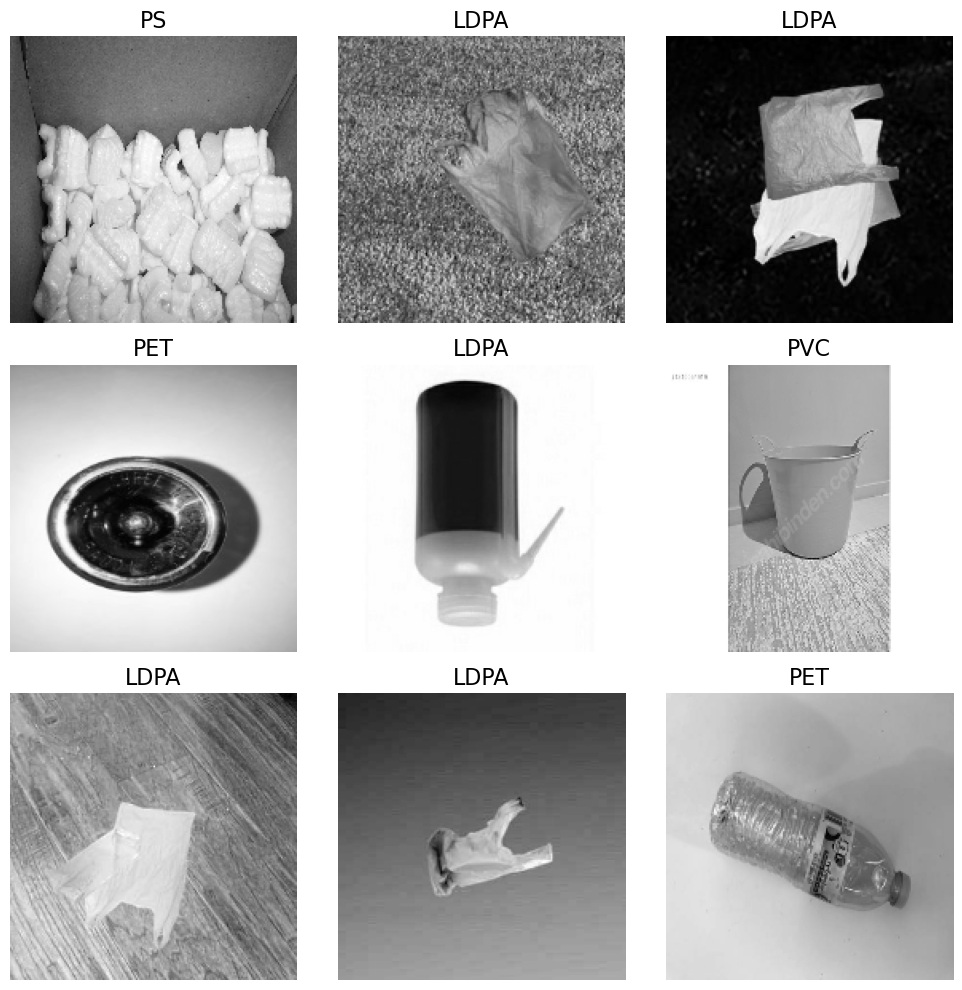

In [13]:
# Função para exibir n imagens com seus rótulos
def plot_grayscale_images(dataset, class_names, n=9):
    plt.figure(figsize=(10, 10))
    
    for images, labels in dataset.take(1):  # Pega o primeiro batch
        for i in range(n):
            ax = plt.subplot(3, 3, i + 1)
            image = images[i].numpy().squeeze()  # Remove o canal [H, W, 1] → [H, W]
            label_index = tf.argmax(labels[i]).numpy()
            plt.imshow(image, cmap='gray')       # Visualiza em escala de cinza
            plt.title(class_names[label_index])
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Usar a função
plot_grayscale_images(train_ds, class_names, n=9)


- As imagens aparecem em tons de cinza e no tamanho determinado

In [14]:
for images, labels in train_ds.take(1):
    print("Formato das imagens:", images.shape)
    print("Rótulos:", labels.numpy())

Formato das imagens: (32, 180, 180, 1)
Rótulos: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


# Construir o modelo CNN simples


In [15]:
# Definir o modelo CNN
model = models.Sequential([
    layers.Input(shape=(180, 180, 1)),  # entrada com 1 canal (escala de cinza)

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # saída com número de classes
])

In [16]:
# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
# Resumo da arquitetura
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,647,303 (25.36 MB)

 Trainable params: 6,647,303 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

 #### Explicação:
- Conv2D: extrai características visuais com filtros.

- MaxPooling2D: reduz a dimensionalidade mantendo os padrões.

- Dropout: ajuda a evitar overfitting.

- Dense final com softmax: saída de probabilidade para cada classe.

# Treinamento do modelo

**usando um callback de parada antecipada (early_stop)**

In [20]:
# Callback de parada antecipada
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Treinamento com medição de tempo
start_train = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)
train_time = time.time() - start_train

print(f"Tempo total de treinamento: {train_time:.2f} segundos")

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 267s 6s/step - accuracy: 0.1565 - loss: 1.9717 - val_accuracy: 0.2260 - val_loss: 1.8529
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 403s 9s/step - accuracy: 0.2113 - loss: 1.8489 - val_accuracy: 0.2212 - val_loss: 1.8272
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 341s 7s/step - accuracy: 0.2660 - loss: 1.7896 - val_accuracy: 0.3462 - val_loss: 1.7478
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 401s 9s/step - accuracy: 0.3781 - loss: 1.6705 - val_accuracy: 0.2933 - val_loss: 1.7821
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 438s 9s/step - accuracy: 0.4722 - loss: 1.4959 - val_accuracy: 0.3870 - val_loss: 1.6815
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 412s 9s/step - accuracy: 0.5403 - loss: 1.3010 - val_accuracy: 0.3918 - val_loss: 1.8242
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 399s 8s/step - accuracy: 0.6095 - loss: 1.0666 - val_accuracy: 0.3630 - val_loss: 1.9729
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 389s 8s/step - accuracy: 0.6613 - loss: 0.9457 - val_accuracy: 0.3534 - v

In [21]:
# Avaliação
loss, acc = model.evaluate(test_ds)
print(f"\nAcurácia no conjunto de teste: {acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2772 - loss: 1.9230

Acurácia no conjunto de teste: 0.35


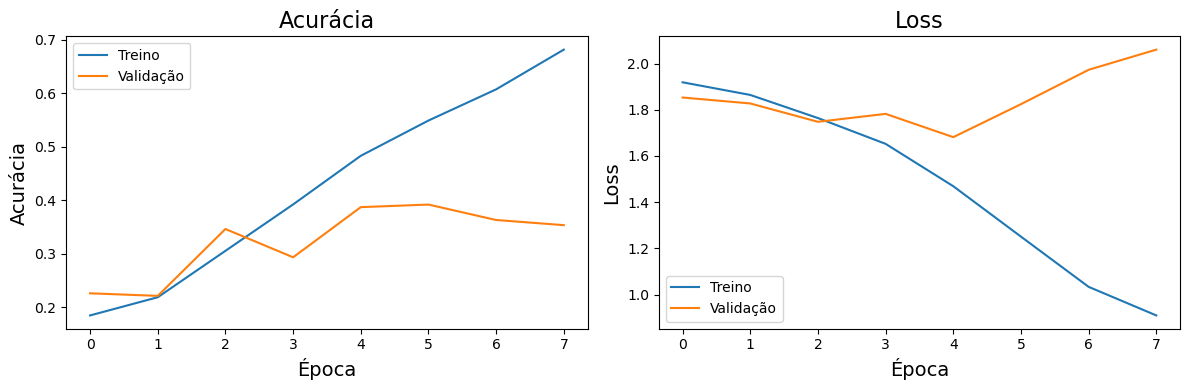

In [22]:
plt.figure(figsize=(12, 4))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Avaliar modelo no conjunto de teste

In [25]:
# Obter previsões do modelo
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Rótulos reais
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 529ms/step


In [26]:
# Relatório com F1-score, precisão, recall
print("Relatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=class_names))

Relatório de Classificação:
              precision    recall  f1-score   support

        HDPE       0.14      0.03      0.05        30
        LDPA       0.51      0.60      0.55        30
       Other       0.33      0.03      0.06        30
         PET       0.15      0.10      0.12        29
          PP       0.45      1.00      0.62        30
          PS       0.25      0.47      0.32        30
         PVC       0.30      0.20      0.24        30

    accuracy                           0.35       209
   macro avg       0.30      0.35      0.28       209
weighted avg       0.31      0.35      0.28       209



# Matriz de confusão


<Figure size 600x600 with 0 Axes>

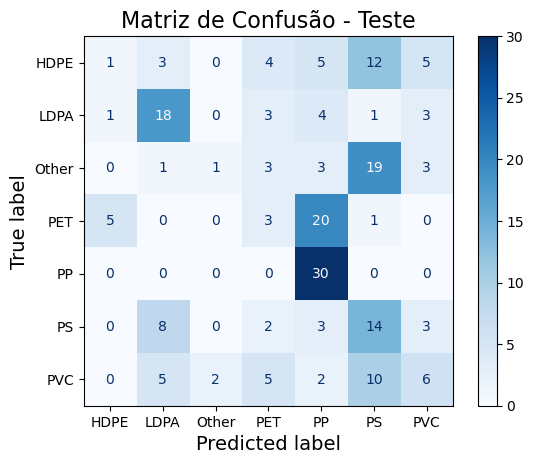

In [28]:
# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusão - Teste")
plt.grid(False)
plt.show()


# Gerar metrics

In [30]:
# Avaliar no conjunto de teste
start_eval = time.time()
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
eval_time = time.time() - start_eval

# Previsões e rótulos verdadeiros
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# F1-score ponderado
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Log loss
logloss = log_loss(y_true, y_pred_probs)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 822ms/step


# Calcular tempo de inferência por imagem



In [32]:
# Número total de imagens no conjunto de teste
num_images = len(y_true)
inference_time_per_image_ms = (eval_time / num_images) * 1000  # em milissegundos


#  Contar número de parâmetros do modelo

In [33]:
# Número total de parâmetros treináveis
num_params = model.count_params()


## Montar o dicionário final

In [35]:
modelo_cnn_gray_results = {
    'model': 'CNN - Grayscale',
    'accuracy': round(test_accuracy, 4),
    'f1_score_weighted': round(f1_weighted, 4),
    'log_loss': round(logloss, 4),
    'train_time_sec': round(train_time, 2),
    'inference_time_per_image_ms': round(inference_time_per_image_ms, 4),
    'num_params': num_params
}

modelo_cnn_gray_results


{'model': 'CNN - Grayscale',
 'accuracy': 0.3493,
 'f1_score_weighted': 0.2824,
 'log_loss': 1.758,
 'train_time_sec': 3061.46,
 'inference_time_per_image_ms': 29.7374,
 'num_params': 6647303}

# Salvar modelo e métricas

In [36]:
# Criar pasta se não existir

model_dir = 'models/07_cnn_grayscale'
os.makedirs(model_dir, exist_ok=True)

# Caminho para salvar
model_path = os.path.join(model_dir, '07_cnn_grayscale_model.keras')

# Salvar modelo no formato Keras
model.save(model_path)

print(f"Modelo salvo em: {model_path}")


Modelo salvo em: models/07_cnn_grayscale\07_cnn_grayscale_model.keras


In [40]:
# Caminho para salvar as métricas
metrics_path = os.path.join(model_dir, 'cnn_grayscale_metrics.json')

# Salvar o dicionário de resultados como JSON
with open(metrics_path, 'w') as f:
    json.dump(modelo_cnn_gray_results, f, indent=4)

print(f"Métricas salvas em: {metrics_path}")

Métricas salvas em: models/07_cnn_grayscale\cnn_grayscale_metrics.json
